In [19]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

In [20]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [21]:
gen6 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen6_sims/data")

In [22]:
X7, y7 = format_data(gen6, 20)
print(X7.shape)
print(y7.shape)

(32396, 20, 2)
(32396, 1)


In [23]:
X7_train, y7_train, X7_test, y7_test = split_data(X7, y7, 0.8)

In [24]:
X7_train, y7_train, X7scale, y7scale = normalise_data(X7_train, y7_train)
X7_test, y7_test, _, _ = normalise_data(X7_test, y7_test)

In [25]:
print(X7_train.shape)

(25916, 20, 2)


In [26]:
print(X7scale.mean_)
print(X7scale.var_)
print(y7scale.mean_)
print(y7scale.var_)
print(X7_train)
print(y7_train)

[4.64964313 4.79602204]
[0.13180816 0.01529391]
[4.65045698]
[0.14445192]
[[[-0.12249679 -1.54325302]
  [-0.13132504 -1.53517092]
  [-0.15352026 -1.5270969 ]
  ...
  [-0.31233482 -1.63351093]
  [-0.31587823 -1.62533817]
  [-0.33366399 -1.61798974]]

 [[-0.13132504 -1.53517092]
  [-0.15352026 -1.5270969 ]
  [-0.15379883 -1.51903094]
  ...
  [-0.31587823 -1.62533817]
  [-0.33366399 -1.61798974]
  [-0.35905871 -1.60983264]]

 [[-0.15352026 -1.5270969 ]
  [-0.15379883 -1.51903094]
  [-0.16105169 -1.59517057]
  ...
  [-0.33366399 -1.61798974]
  [-0.35905871 -1.60983264]
  [-0.38529571 -1.60168376]]

 ...

 [[ 0.83655916  0.66856604]
  [ 0.81782823  0.6992628 ]
  [ 0.83091427  0.7072249 ]
  ...
  [ 0.88092389  0.78581149]
  [ 0.86326365  0.79368887]
  [ 0.88111523  0.80155858]]

 [[ 0.81782823  0.6992628 ]
  [ 0.83091427  0.7072249 ]
  [ 0.84529562  0.71517918]
  ...
  [ 0.86326365  0.79368887]
  [ 0.88111523  0.80155858]
  [ 0.86210795  0.80942065]]

 [[ 0.83091427  0.7072249 ]
  [ 0.845295

In [27]:
lstm7=keras.Sequential() #Set up the architecture of the model

lstm7.add(layers.LSTM(units=16, input_shape=(X7_train.shape[1], X7_train.shape[2])))
lstm7.add(layers.Dropout(0.2))

lstm7.add(layers.Dense(units=1))

print(lstm7.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
lstm7.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history7 = lstm7.fit(X7_train, y7_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 20732 samples, validate on 5184 samples
Epoch 1/10
20732/20732 [==============================] - 29s 1ms/sample - loss: 0.1402 - val_loss: 0.0100
Epoch 2/10
20732/20732 [==============================] - 26s 1ms/sample - loss: 0.0263 - val_loss: 0.0056
Epoch 3/10
20732/20732 [==============================] - 28s 1ms/sample - loss: 0.0211 - val_loss: 0.0090
Epoch 4/10
20732/20732 [==============================] - 25s 1ms/sample - loss: 0.0206 - val_loss: 0.0062
Epoch 5/10
20732/20732 [==============================] - 29s 1ms/sample - loss: 0.0204 - val_loss: 0.0062
Epoch 6/10
20732/20732 [==============================] - 27s 1ms/sample - loss: 0.0194 - val_loss: 0.0050
Epoch 7/10
20732/20732 [==============================] - 24s 1ms/sample - loss: 0.0185 - val_loss: 0.0074
Epoch 8/10
20732/20732 [==============================] - 24s 1ms/sample - loss: 0.0177 - val_loss: 0.0312
Epoch 9/10
20732/20732 [==============================] - 25s 1ms/sample - loss: 0.0184 - val_l

In [29]:
lstm7.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm7")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm7/assets


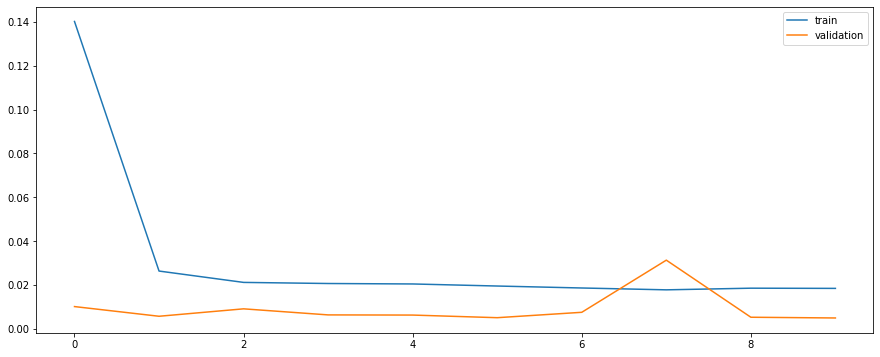

In [30]:
plt.figure(figsize=(15,6))
plt.plot(history7.history["loss"], label="train")
plt.plot(history7.history["val_loss"], label="validation")
plt.legend()

In [31]:
y7_pred = lstm7.predict(X7_test)
y7_train_inv = y7scale.inverse_transform(y7_train.reshape(1, -1))
y7_test_inv = y7scale.inverse_transform(y7_test.reshape(1, -1))
y7_pred_inv  = y7scale.inverse_transform(y7_pred)

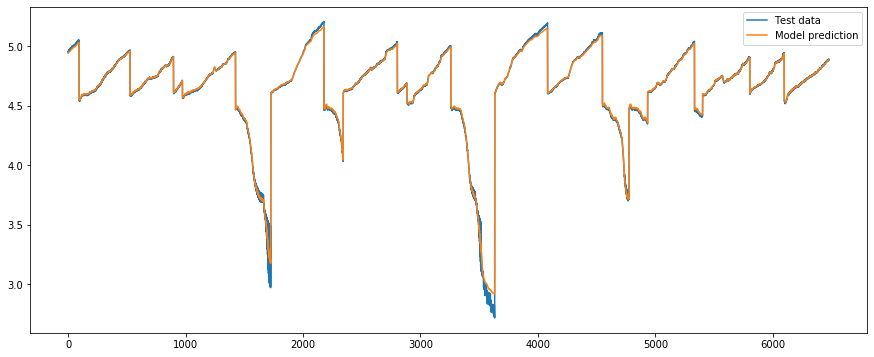

In [32]:
plt.figure(figsize=(15,6))
plt.plot(y7_test_inv.flatten(), label="Test data")
plt.plot(y7_pred_inv.flatten(), label="Model prediction")
plt.legend()